In [1]:
# %load_ext autoreload
# %autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import numpy as np
import numpyro

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import arviz as az

from tabulate import tabulate
import numpy as np
from collections import OrderedDict
from itertools import cycle

In [3]:
CODE_DIR = "/home/cbarkhof/fall-2021"
import sys
sys.path.append(CODE_DIR)

In [4]:
import os
import torch
import pandas as pd

from transformers import RobertaTokenizerFast
import torch.distributions as td

from analysis_steps import make_run_overview_df
from utils import load_checkpoint_model_for_eval

from analysis.MNIST_analysis.analysis_utils import get_n_data_samples_x_y

ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"
CHECKPOINT_DIR = f"{CODE_DIR}/run_files/checkpoints"

SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

SURPRISAL_SAMPLE_FILE = "surprisal_sample.pt"
SURPRISAL_DATA_FILE = "surprisal_data.pt"
SURPRISAL_COND_SAMPLE_FILE = "surprisal_conditional_sample.pt"

TEST_VALID_EVAL_FILE = "test-valid-results.pt"

BASE_ALPHA = 0.001
MMD_REDO_FILE = f"mmd_redo-base-alpha-{BASE_ALPHA}.pt"

prefixes = ["(29-nov ptb-beta-vae)", "(29-nov yahoo-beta-vae)", "(29-nov drop yahoo-beta-vae)"]
overview_df = make_run_overview_df(prefixes, add_data_group=False)
overview_df

,objective,dataset,l_rate,dropout,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0.500000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.5] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.750000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.500000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0.100000,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.1] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.750000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.500000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,0.250000,0,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=0.0] | ST...
yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa,BETA-VAE,yahoo_answer,0,1,1,0,0,0,strong_distil_roberta_decoder,(29-nov drop yahoo-beta-vae) B-VAE[b=1.0] | ST...


In [5]:
max_samples = -1

model_samples = dict()

for i, (clean_name, row) in enumerate(overview_df.iterrows()):
    print(i, clean_name)
    
    save_dir = f"{ANALYSIS_DIR}/{row.run_name}"
    conditional_sample_file = f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}"
    sample_file = f"{save_dir}/{SAMPLE_FILE}"
    
    model_samples[clean_name] = dict()
    
    if os.path.exists(conditional_sample_file):
        cond_samples = torch.load(conditional_sample_file)
        
        model_samples[clean_name]["conditional_sample"] = cond_samples["valid"]["cond_sample_x"]
        model_samples[clean_name]["conditional_condition"] = cond_samples["valid"]["original_input_ids"]
        
    if os.path.exists(sample_file):
        samples = torch.load(sample_file)
        model_samples[clean_name]["unconditional_sample"] = samples["x"]

0 yahoo_answer | drop-0.25 | BETA-VAE beta 0.5 dec: Strong roBERTa
1 yahoo_answer | drop-1 | BETA-VAE beta 0.1 dec: Strong roBERTa
2 yahoo_answer | drop-0.75 | BETA-VAE beta 0.1 dec: Strong roBERTa
3 yahoo_answer | drop-0.5 | BETA-VAE beta 0.1 dec: Strong roBERTa
4 yahoo_answer | drop-0.25 | BETA-VAE beta 0.1 dec: Strong roBERTa
5 yahoo_answer | drop-1 | BETA-VAE beta 0 dec: Strong roBERTa
6 yahoo_answer | drop-0.75 | BETA-VAE beta 0 dec: Strong roBERTa
7 yahoo_answer | drop-0.5 | BETA-VAE beta 0 dec: Strong roBERTa
8 yahoo_answer | drop-0.25 | BETA-VAE beta 0 dec: Strong roBERTa
9 yahoo_answer | drop-1 | BETA-VAE beta 1 dec: Strong roBERTa
10 yahoo_answer | drop-0.75 | BETA-VAE beta 1 dec: Strong roBERTa
11 yahoo_answer | drop-0.5 | BETA-VAE beta 1 dec: Strong roBERTa
12 yahoo_answer | drop-0.25 | BETA-VAE beta 1 dec: Strong roBERTa
13 yahoo_answer | drop-1 | BETA-VAE beta 0.5 dec: Strong roBERTa
14 yahoo_answer | drop-0.75 | BETA-VAE beta 0.5 dec: Strong roBERTa
15 yahoo_answer | dro

In [6]:
valid_yahoo_input_ids, _ = get_n_data_samples_x_y(
    language_dataset_name="yahoo_answer",
    image_or_language="language", 
    N_samples=2000, 
    phase="valid")
valid_yahoo_input_ids.shape

Is file!
train 140000
validation 6000
test 6000
Returns concatted input_ids, attention_masks tensors


torch.Size([2000, 64])

In [7]:
model_sample_lengths = dict()

def get_length_of_chunk(chunk, eos_token_id=2):
    lens = []
    for s_i in chunk.tolist():
        length = s_i.index(eos_token_id) + 1 if eos_token_id in s_i else len(s_i)
        lens.append(length)
    return lens

keys = ["conditional_sample", "conditional_condition", "unconditional_sample"]

for model_name, samples in model_samples.items():
    model_sample_lengths[model_name] = dict()
    
    for k in keys:
        if k == "conditional_condition":
            chunk = samples[k][:, :-1]
        else:
            chunk = samples[k]
        
        lens = get_length_of_chunk(chunk)
        model_sample_lengths[model_name][k] = lens

In [8]:
data_lengths = get_length_of_chunk(valid_yahoo_input_ids[:, :-1])

# Plot data group - conditional samples - unconditional samples

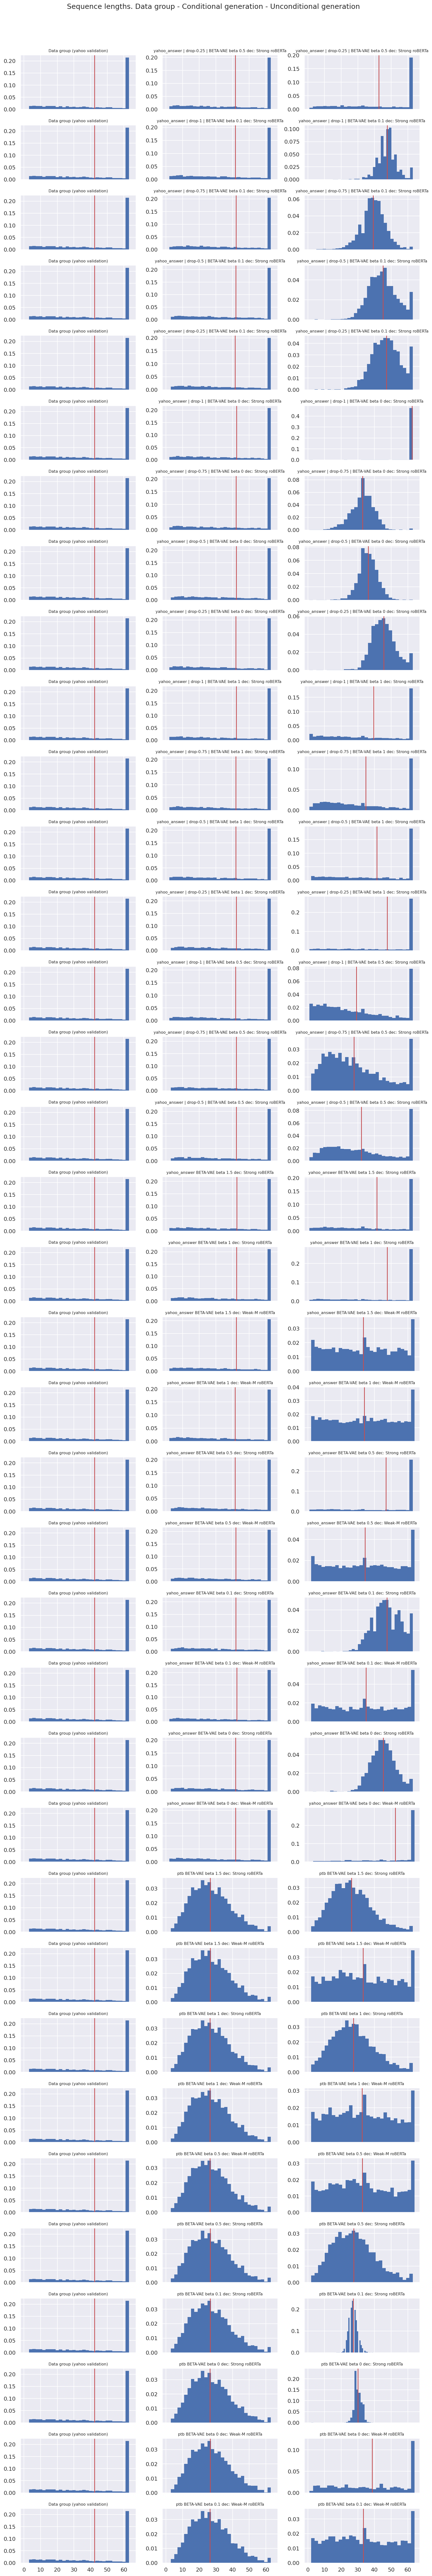

In [11]:
ncols = 3
nrows = len(model_samples.items())

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(ncols*4, nrows*2))

hist_kwargs = dict(density=True, bins=30, lw=0)

for i in range(nrows):
    axs[i, 0].hist(data_lengths, **hist_kwargs)
    axs[i, 0].axvline(np.mean(data_lengths), color='r')
    axs[i, 0].set_title("Data group (yahoo validation)", size=8)

for i, (model_name, lenghts) in enumerate(model_sample_lengths.items()):
    for j, k in enumerate(["conditional_condition", "unconditional_sample"]):
        
        axs[i, j+1].hist(lenghts[k], **hist_kwargs)
        axs[i, j+1].axvline(np.mean(lenghts[k]), color='r')
        axs[i, j+1].set_title(model_name, size=8)

plt.suptitle("Sequence lengths. Data group - Conditional generation - Unconditional generation", y=1.01)
plt.tight_layout()

In [9]:
palette = cycle(sns.color_palette())
color_m = next(palette)
color_f = next(palette)

In [10]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.contrib.indexing import Vindex

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
print(f"Running on NumPryo v{numpyro.__version__}")

Running on NumPryo v0.8.0


In [37]:
import functools

def model_beta_binomial(self, y=None):
    print("model_beta_binomial")
    """
    Pyro joint distribution.

    Parameter:

    y: observations as returned by self.prepare or None. 
        If None, the 'obs' node of the graphical model will be resampled.
    """

    N, G = self.N, self.G
    T = self.T
    
    total_count = 63
    
    with numpyro.plate("components", T):  
#         # construct the components
#         # [T]
#         lamb = numpyro.sample("lambda", dist.Gamma(self.gamma_shape[0], self.gamma_shape[1]))   
#         rate = numpyro.deterministic("rate", jnp.cumsum(lamb))  # we could use jnp.sort, but cumsum is simpler 
        
        # https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html (Model 3 section)
        # The beta distribution is the conjugate prior for the binomial, meaning that the posterior is 
        # known to be a beta distribution. This also allows us to interpret the prior’s parameters as 
        # prior data, with α−1 being the prior number of successes and β−1 being the prior number of failures, 
        # and α=β=1 corresponding to no prior observations and thus a uniform distribution.
        a = np.mean(self.y) + 1 # alpha = # successes + 1
        b = np.mean(total_count - (self.y)) + 1 # beta = # failures + 1
        lamb = numpyro.sample("lambda", dist.Beta(a, b))
        beta = numpyro.deterministic("beta", jnp.cumsum(lamb))  # we could use jnp.sort, but cumsum is simpler 

    # Sample mixing weights    
    with numpyro.plate("DPs", G):
        # [G, T-1]
        mix_beta = numpyro.sample(
            "mix_beta", 
            dist.Beta(
                np.ones(1), 
                np.ones(1) * self.DP_alpha
            ).expand((T-1,)).to_event(1)
        )

    # [G, T]
    omega = numpyro.deterministic("omega", self.mix_weights(mix_beta))

    with numpyro.plate("observations", N):   
        # [N, T]
        omega_x = numpyro.deterministic("omega_x", omega[self.x])

        # [N]
        # BUG: during .run() an omega of shape [2000, 5] leads to a z of [5, 1]? [2000,]
        z = numpyro.sample("z", dist.Categorical(probs=omega_x))

        # [N]
        beta_z = numpyro.deterministic("beta_z", beta[z])

        # [N]
        # Construct the likelihood function            
        return numpyro.sample("y", dist.Binomial(probs=beta_z, total_count=total_count), obs=y)
    
def model_rate_poisson(self, y=None):
    print("model_rate_poisson")
    """
    Pyro joint distribution.

    Parameter:

    y: observations as returned by self.prepare or None. 
        If None, the 'obs' node of the graphical model will be resampled.
    """

    N, G = self.N, self.G
    T = self.T

    with numpyro.plate("components", T):  
        # construct the components
        # [T]
        lamb = numpyro.sample("lambda", dist.Gamma(self.gamma_shape[0], self.gamma_shape[1]))   
        rate = numpyro.deterministic("rate", jnp.cumsum(lamb))  # we could use jnp.sort, but cumsum is simpler 

    # Sample mixing weights    
    with numpyro.plate("DPs", G):
        # [G, T-1]
        beta = numpyro.sample(
            "beta", 
            dist.Beta(
                np.ones(1), 
                np.ones(1) * self.DP_alpha
            ).expand((T-1,)).to_event(1)
        )
    
    print("beta:", beta.shape)

    # [G, T]
    omega = numpyro.deterministic("omega", self.mix_weights(beta))

    with numpyro.plate("observations", N):   
        # [N, T]
        omega_x = numpyro.deterministic("omega_x", omega[self.x])

        # [N]
        # BUG: during .run() an omega of shape [2000, 5] leads to a z of [5, 1]?
        z = numpyro.sample("z", dist.Categorical(probs=omega_x))
        print("omega_x, z", omega_x.shape, z.shape)

        # [N]
        rate_z = numpyro.deterministic("rate_z", rate[z])
#         print("rate_z")

        # [N]
        # Construct the likelihood function            
        return numpyro.sample("y", dist.Poisson(rate_z), obs=y)

class DPMixture:
    def __init__(self, model_fn, group_names: list, observations: list, 
                 gamma_shape=[1., 1.], DP_alpha=1., num_comps=5,
                 num_samples=1000, num_chains=1, num_warmup=100):
        
        self.model = functools.partial(model_fn, self)

        self.gamma_shape = gamma_shape
        self.DP_alpha = DP_alpha
        self.T = num_comps

        self.group_names = group_names
        self.G = len(group_names)
        
        self.N = sum(len(y) for y in observations)
        # [N]
        self.x = np.concatenate([[g] * len(y) for g, y in enumerate(observations)])
        self.y = np.concatenate(observations)
        
        print("x, y shapes", self.x.shape, self.y.shape)
        print("N", self.N)
        print("G", self.G)
        print("T", self.T)

        self.num_samples = num_samples
        self.num_chains = num_chains
        self.num_warmup = num_warmup

        self.rng_key = random.PRNGKey(0)

        nuts_kernel = NUTS(self.model)
        self.mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)

        self.prior_predictive = None
        self.posterior_predictive = None
        self.posterior_samples = None

    @classmethod
    def mix_weights(cls, beta):
        beta1m_cumprod = (1 - beta).cumprod(-1)
        return jnp.pad(beta, ((0, 0), (0, 1)), constant_values=1) * jnp.pad(beta1m_cumprod, ((0, 0), (1, 0)), constant_values=1)

    def model(self, y=None):
        pass
    
    def run(self):
        self.mcmc.run(self.rng_key, y=self.y)
        self.mcmc.print_summary()
        self.posterior_samples = self.mcmc.get_samples(group_by_chain=False)
        print("posterior samples shapes:")
        for k, v in self.posterior_samples.items():
            print(k, v.shape)

    def make_prior_predictive(self, num_prior_samples=100):        
        if self.prior_predictive is None:
            self.prior_predictive = Predictive(self.model, num_samples=num_prior_samples)

    def draw_prior_predictions(self):
        if self.prior_predictive is None:
            self.make_prior_predictive()
        rng_key, rng_key_ = random.split(self.rng_key)        
        return self.prior_predictive(rng_key_, y=None)

    def make_posterior_predictive(self):
        if self.posterior_samples is None:
            raise RuntimeError("You need to run the sampler first")        
        if self.posterior_predictive is None:
            self.posterior_predictive = Predictive(self.model, self.posterior_samples)        

    def draw_posterior_predictions(self, plot=False):
        if self.posterior_predictive is None:
            self.make_posterior_predictive()        
        rng_key, rng_key_ = random.split(self.rng_key)
        return self.posterior_predictive(rng_key_, y=None)

In [31]:
def plot_predictions(model, samples, bins=[20, 100], density=[True, True], sharex=True, sharey=True):
    fig, ax = plt.subplots(model.G, 2, sharex=sharex, sharey=sharey, figsize=(10, 5))
    if model.G == 1:
        ax = ax.reshape(1, -1)
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        c = next(pal)
        _ = ax[k, 0].hist(yk, bins=bins[0], color=c, density=density[0])
        _ = ax[k, 0].set_xlabel(f'obs: {model.group_names[k]}')
        _ = ax[k, 1].hist(yk_.flatten(), bins=bins[1], color=c, density=density[1])
        _ = ax[k, 1].set_xlabel(f'predictive: {model.group_names[k]}')

    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

def plot_checks(model, samples, bins=30):
    fig, ax = plt.subplots(model.G, 4, sharex=False, figsize=(15, 5))
    if model.G == 1:
        ax = ax.reshape(1, -1)
    pal = cycle(sns.color_palette())
    for k in range(model.G):
        c = next(pal)
        yk = model.y[model.x==k]
        yk_ = samples[:,model.x==k]
        
        _ = ax[k, 0].hist(np.mean(yk_, 1), bins=bins, color=c, label='pred' if k == 0 else None)
        _ = ax[k, 0].axvline(np.mean(yk), color='black', linestyle='--', label='obs' if k == 0 else None)    
        _ = ax[k, 0].set_xlabel(f'E[Y{k}]')
        
        _ = ax[k, 1].hist(np.std(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 1].axvline(np.std(yk), color='black', linestyle='--')
        _ = ax[k, 1].set_xlabel(f'std[Y{k}]')

        _ = ax[k, 2].hist(np.median(yk_, 1), color=c, bins=bins)    
        _ = ax[k, 2].axvline(np.median(yk), color='black', linestyle='--')
        _ = ax[k, 2].set_xlabel(f'median[Y{k}]')

        pvalues = np.mean(yk_ > yk, 1)
        _ = ax[k, 3].hist(pvalues, bins=bins)
        _ = ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')
        _ = ax[k, 3].axvline(np.median(pvalues), color='black', linestyle=':', label='median' if k==0 else None)

    _ = fig.legend(loc='upper center', ncol=3)
    fig.tight_layout(h_pad=2, w_pad=2)
    fig.show()

In [43]:
# model = DPMixture(
#     model_rate_poisson,
#     ['data_group'], 
#     [np.array(data_lengths)], 
#     gamma_shape=[1., 0.1], 
#     num_comps=5,
#     DP_alpha=0.1, 
#     num_chains=NUM_CHAINS, num_warmup=500, num_samples=2000)

mix = np.concatenate([np.random.poisson(10, size=(500,)), np.random.poisson(5, size=(500,))])
                                        
model = DPMixture(
    model_rate_poisson,
    ['poisson_5', 'poisson_10', 'poisson_mix_5_10'], 
    [np.random.poisson(5, size=(1000,)), np.random.poisson(10, size=(1000,)), mix], 
    gamma_shape=[1., 0.1], 
    num_comps=5,
    DP_alpha=0.1, 
    num_chains=NUM_CHAINS, num_warmup=500, num_samples=2000)

# model = DPMixture(
#     model_rate_poisson,
#     ['data_group', 'data'], 
#     [np.array(data_lengths), np.array(data_lengths)], 
#     gamma_shape=[1., 0.1], 
#     num_comps=5,
#     DP_alpha=0.1, 
#     num_chains=NUM_CHAINS, num_warmup=500, num_samples=2000)

# with numpyro.handlers.seed(rng_seed=1):
#     #trace = numpyro.handlers.trace(model.model).get_trace(y=None)
#     trace = numpyro.handlers.log(model.model).get_trace(y=None)

# print(numpyro.util.format_shapes(trace))

# with numpyro.handlers.seed(rng_seed=1):
#     trace = numpyro.handlers.trace(model.model).get_trace(y=model.y)
# print(numpyro.util.format_shapes(trace))

x, y shapes (3000,) (3000,)
N 3000
G 3
T 5


In [54]:
mix.shape

(1000,)

In [44]:
prior_samples = model.draw_prior_predictions()

model_rate_poisson
beta: (3, 4)
omega_x, z (3000, 5) (3000,)


In [45]:
print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))

rv       shape
-------  --------------
beta     (100, 3, 4)
lambda   (100, 5)
omega    (100, 3, 5)
omega_x  (100, 3000, 5)
rate     (100, 5)
rate_z   (100, 3000)
y        (100, 3000)
z        (100, 3000)


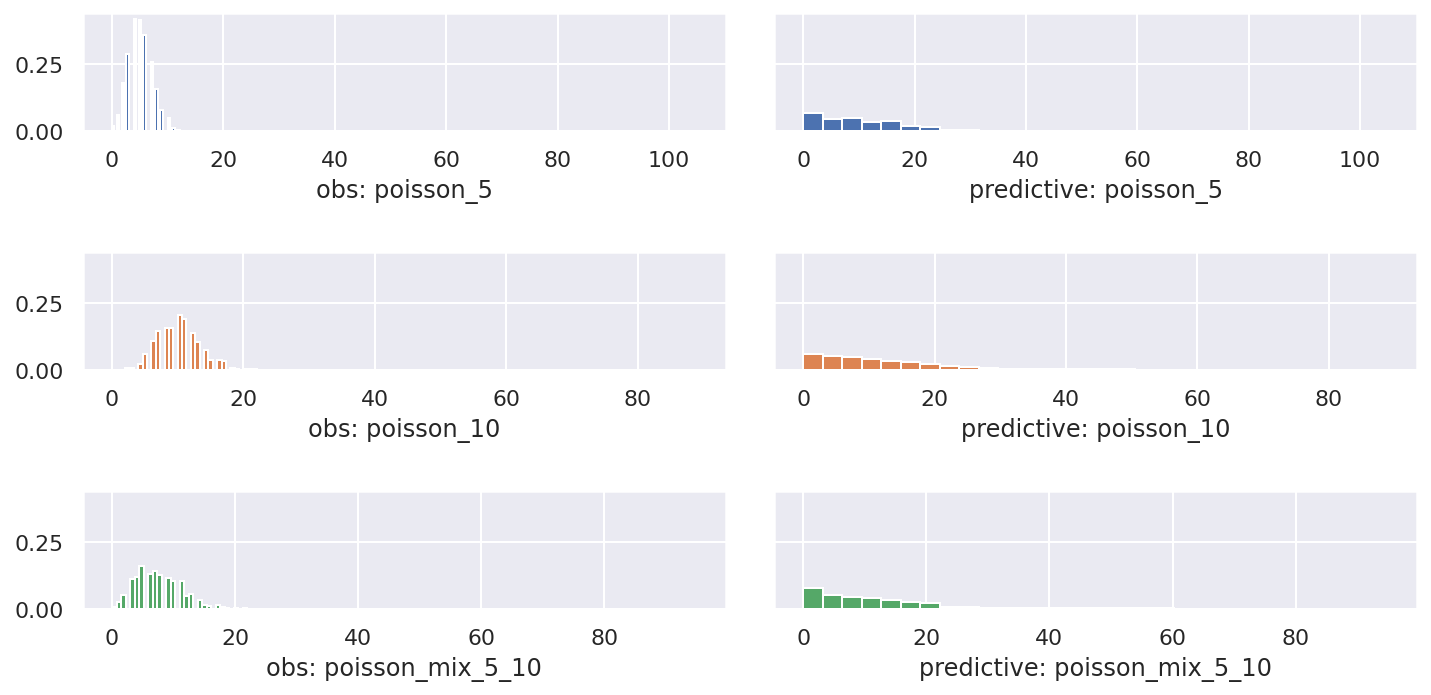

In [46]:
_ = plot_predictions(model, prior_samples['y'], sharex='row', bins=[30, 30])

In [58]:
# model.y[model.x == 2].shape

(1000,)

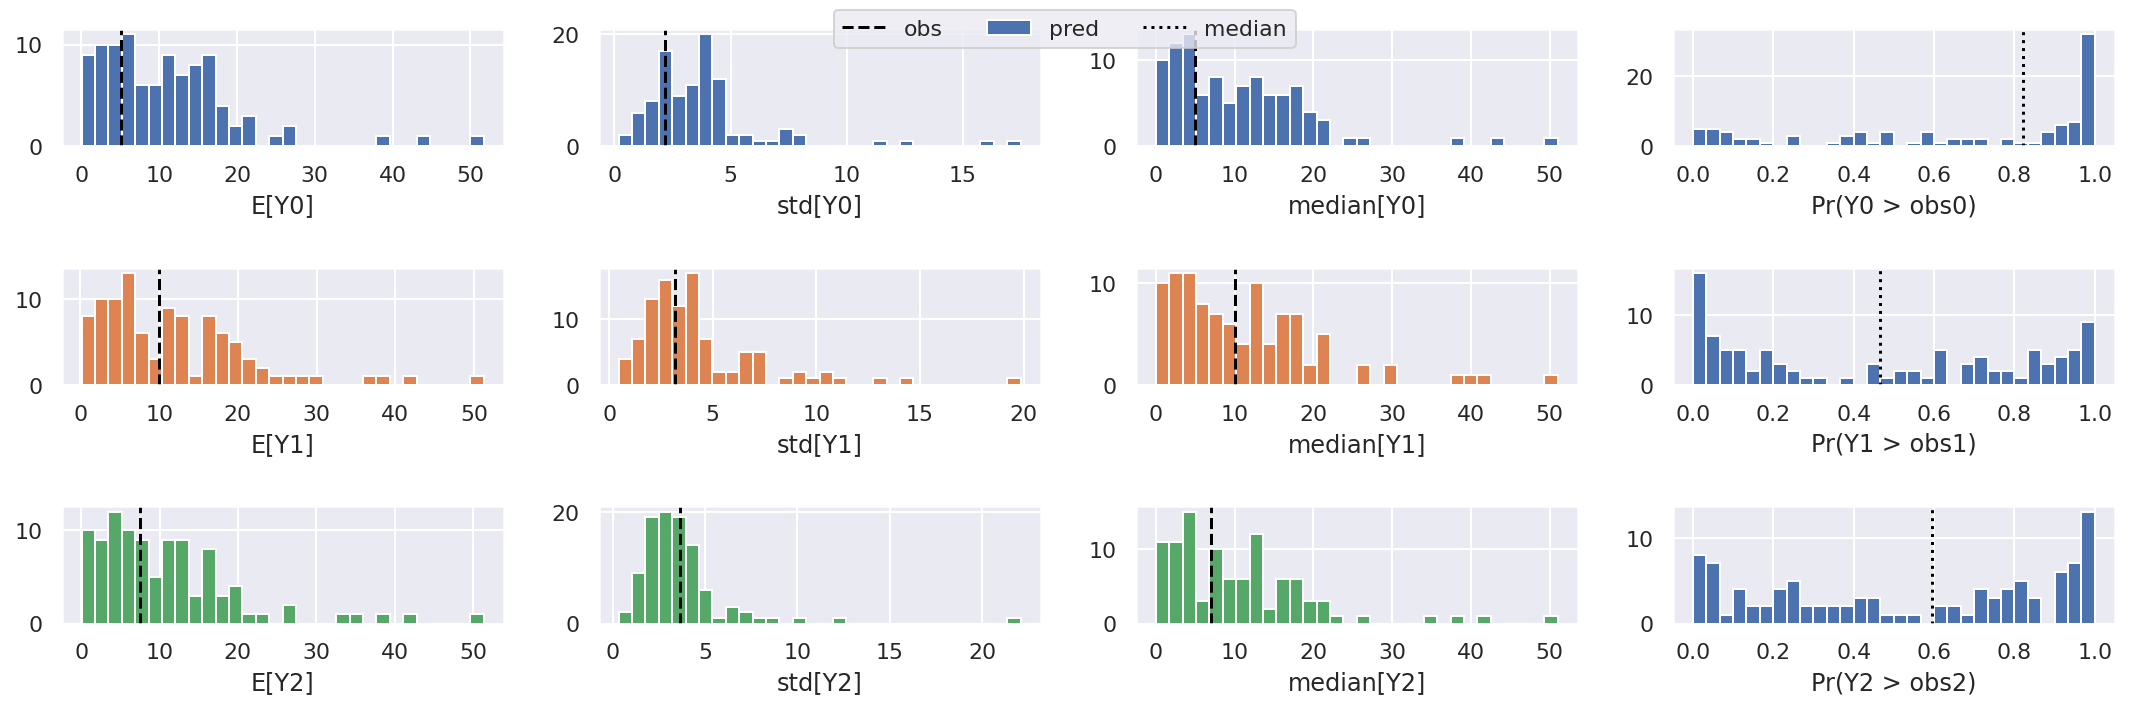

In [47]:
_ = plot_checks(model, prior_samples['y'])

In [48]:
model.run()

model_rate_poisson
beta: (3, 4)
omega_x, z (3000, 5) (3000,)
model_rate_poisson
beta: (3, 4)
omega_x, z (3000, 5) (5, 1)


  0%|          | 0/2500 [00:00<?, ?it/s]

model_rate_poisson
beta: (3, 4)
omega_x, z (3000, 5) (5, 1)


sample: 100%|██████████| 2500/2500 [03:02<00:00, 13.67it/s, 31 steps of size 1.29e-01. acc. prob=0.85] 


model_rate_poisson
beta: (3, 4)
omega_x, z (3000, 5) (3000,)

                mean       std    median      5.0%     95.0%     n_eff     r_hat
 beta[0,0]      1.00      0.00      1.00      1.00      1.00   1973.22      1.00
 beta[0,1]      0.90      0.20      1.00      0.63      1.00   2278.87      1.00
 beta[0,2]      0.88      0.22      1.00      0.53      1.00   2244.07      1.00
 beta[0,3]      0.89      0.21      1.00      0.58      1.00   2186.34      1.00
 beta[1,0]      0.01      0.01      0.01      0.00      0.02   1528.20      1.00
 beta[1,1]      0.97      0.10      1.00      0.93      1.00    972.15      1.00
 beta[1,2]      0.91      0.20      1.00      0.68      1.00   2077.09      1.00
 beta[1,3]      0.89      0.21      1.00      0.58      1.00   2078.83      1.00
 beta[2,0]      0.51      0.03      0.51      0.46      0.55   1995.36      1.00
 beta[2,1]      0.99      0.06      1.00      0.98      1.00   1213.23      1.00
 beta[2,2]      0.90      0.20      1.00      0

In [49]:
posterior_samples = model.draw_posterior_predictions()

model_rate_poisson
beta: (3, 4)
omega_x, z (3000, 5) (3000,)


In [50]:
print(tabulate([(k, v.shape) for k, v in posterior_samples.items()], headers=['rv', 'shape']))

rv       shape
-------  ---------------
omega    (2000, 3, 5)
omega_x  (2000, 3000, 5)
rate     (2000, 5)
rate_z   (2000, 3000)
y        (2000, 3000)
z        (2000, 3000)


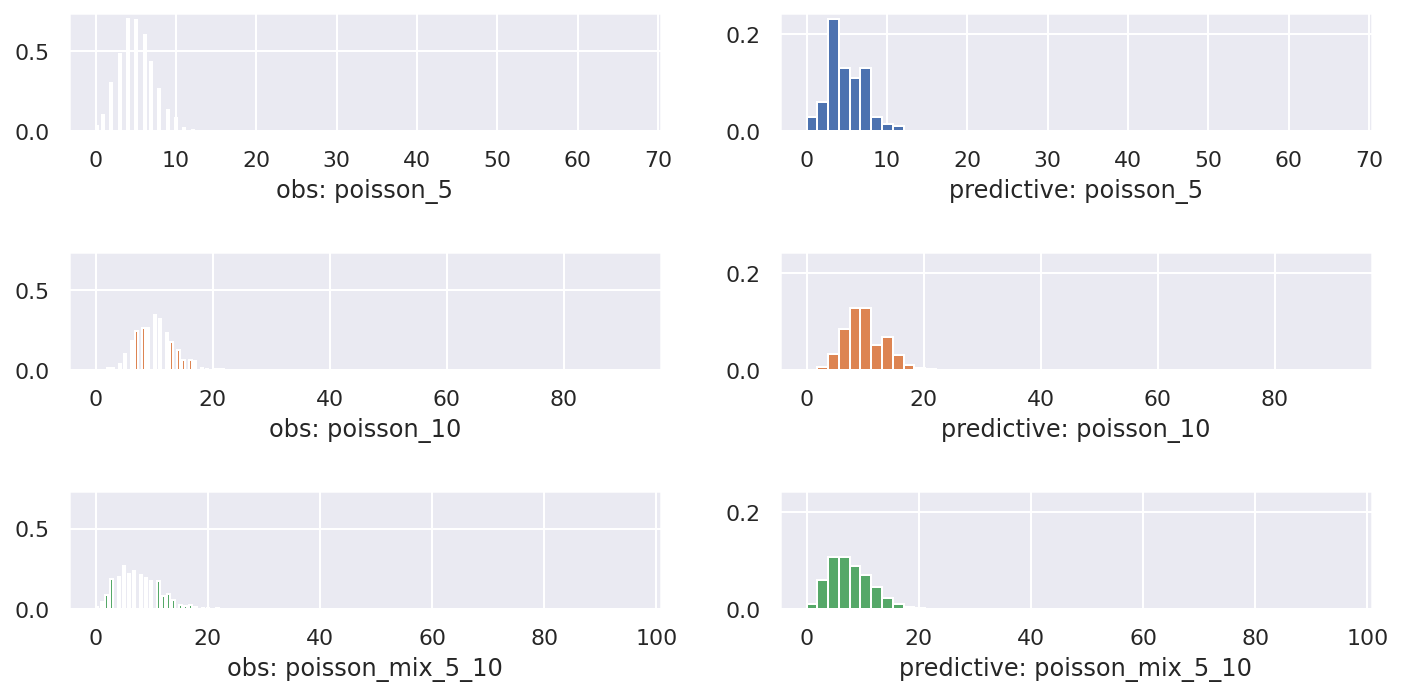

In [51]:
_ = plot_predictions(model, posterior_samples['y'], bins=[50, 50], sharex='row', sharey='col')

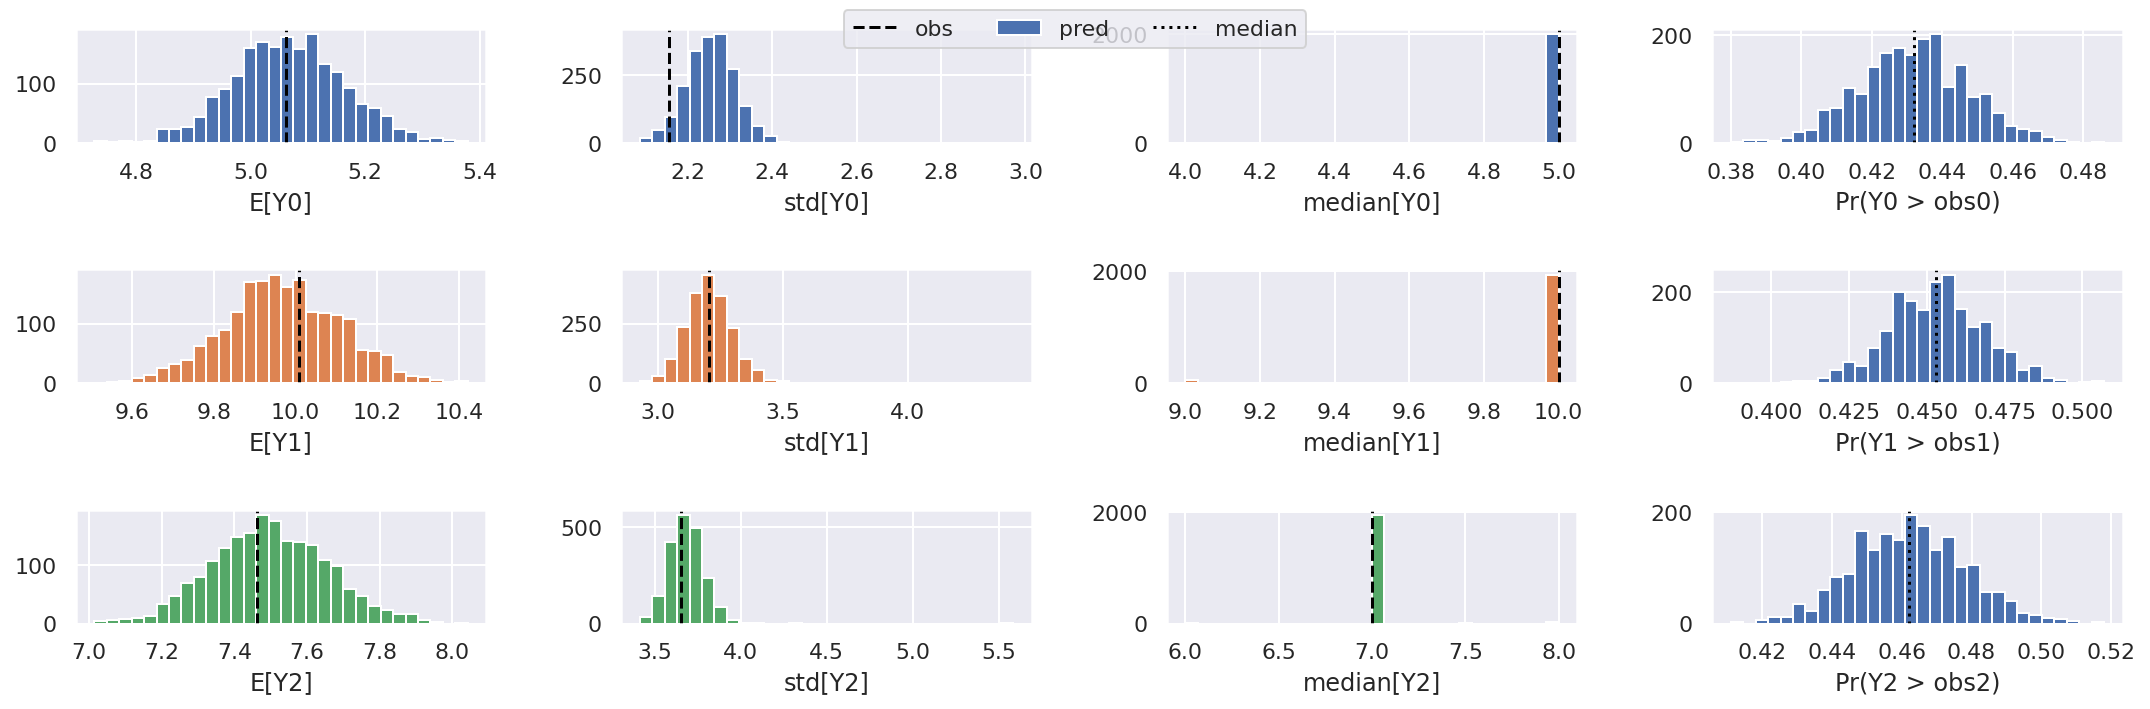

In [52]:
_ = plot_checks(model, posterior_samples['y'])

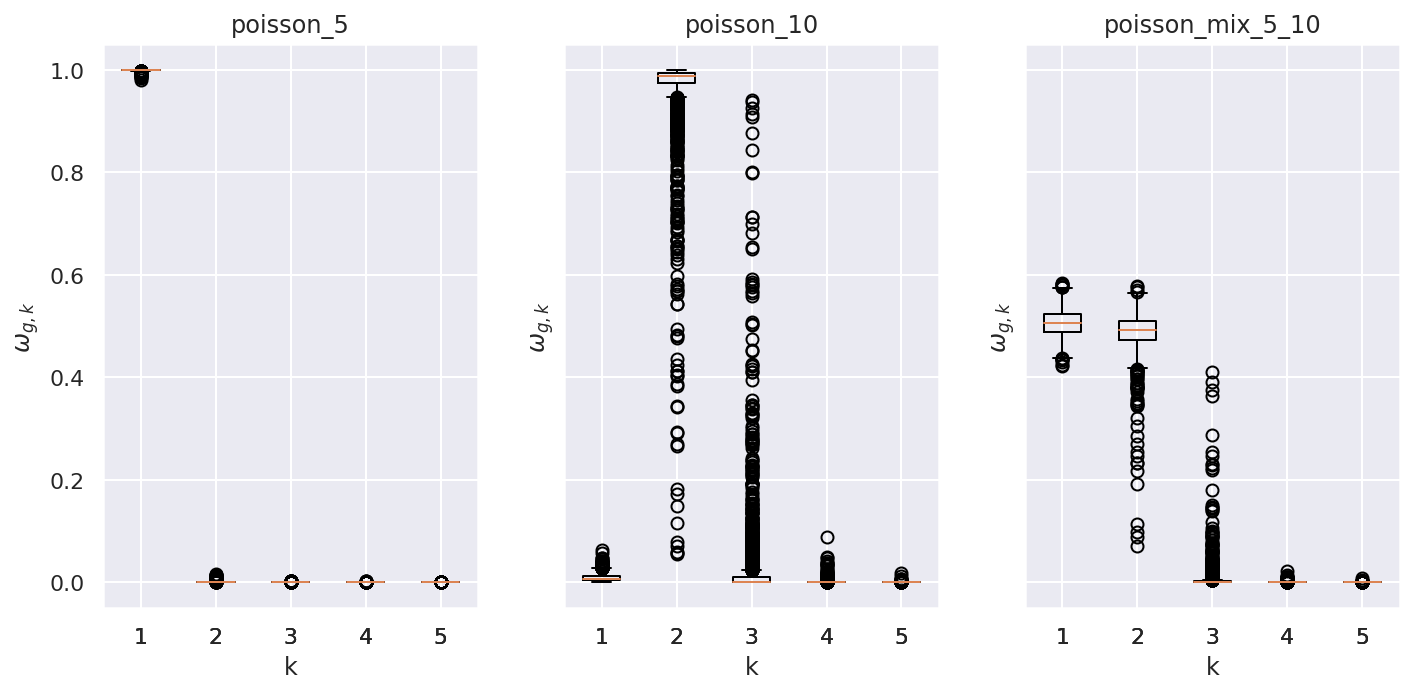

In [59]:
fig, ax = plt.subplots(1, model.G, sharex=True, sharey=True, figsize=(10, 5))
for g in range(model.G):
    _ = ax[g].boxplot(posterior_samples['omega'][:,g,:].transpose())
#     _ = ax[g].set_xticklabels(np.arange(model.T))
    _ = ax[g].set_title(model.group_names[g])
    _ = ax[g].set_xlabel('k')
    _ = ax[g].set_ylabel(r'$\omega_{g,k}$')
fig.tight_layout(h_pad=2, w_pad=2)

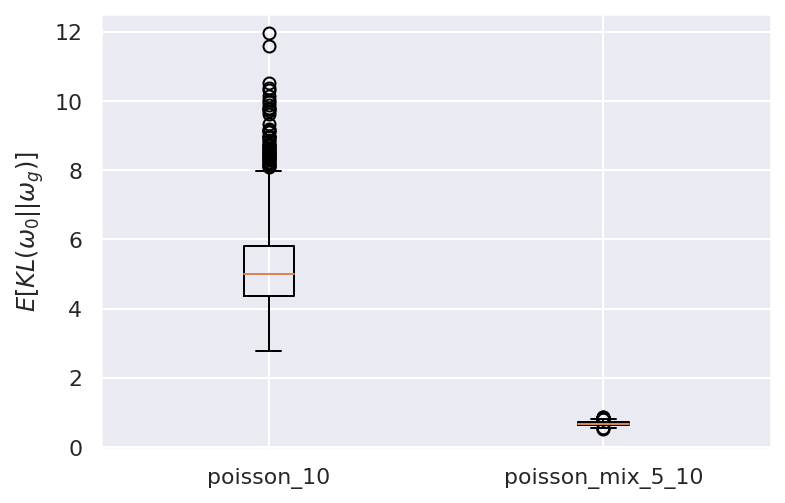

In [60]:
kls = []
for g in range(model.G):
    p = posterior_samples['omega'][:,0,:]
    q = posterior_samples['omega'][:,g,:]
    kls.append((p * (np.log(p) - np.log(q))).sum(-1))

_ = plt.boxplot(kls[1:])
_ = plt.ylabel(r'$E[KL(\omega_0||\omega_g)]$')
_ = plt.xticks(np.arange(model.G - 1) + 1, model.group_names[1:]) 

In [61]:
# import scipy.stats as stats

# def plot_poisson_pmf(ax, rate, color, linestyle, num_points=100):
#     x = np.linspace(0, 4*rate, num_points)
#     return ax.plot(x, stats.norm.pdf(x, mu, sigma), color=color, linestyle=linestyle)

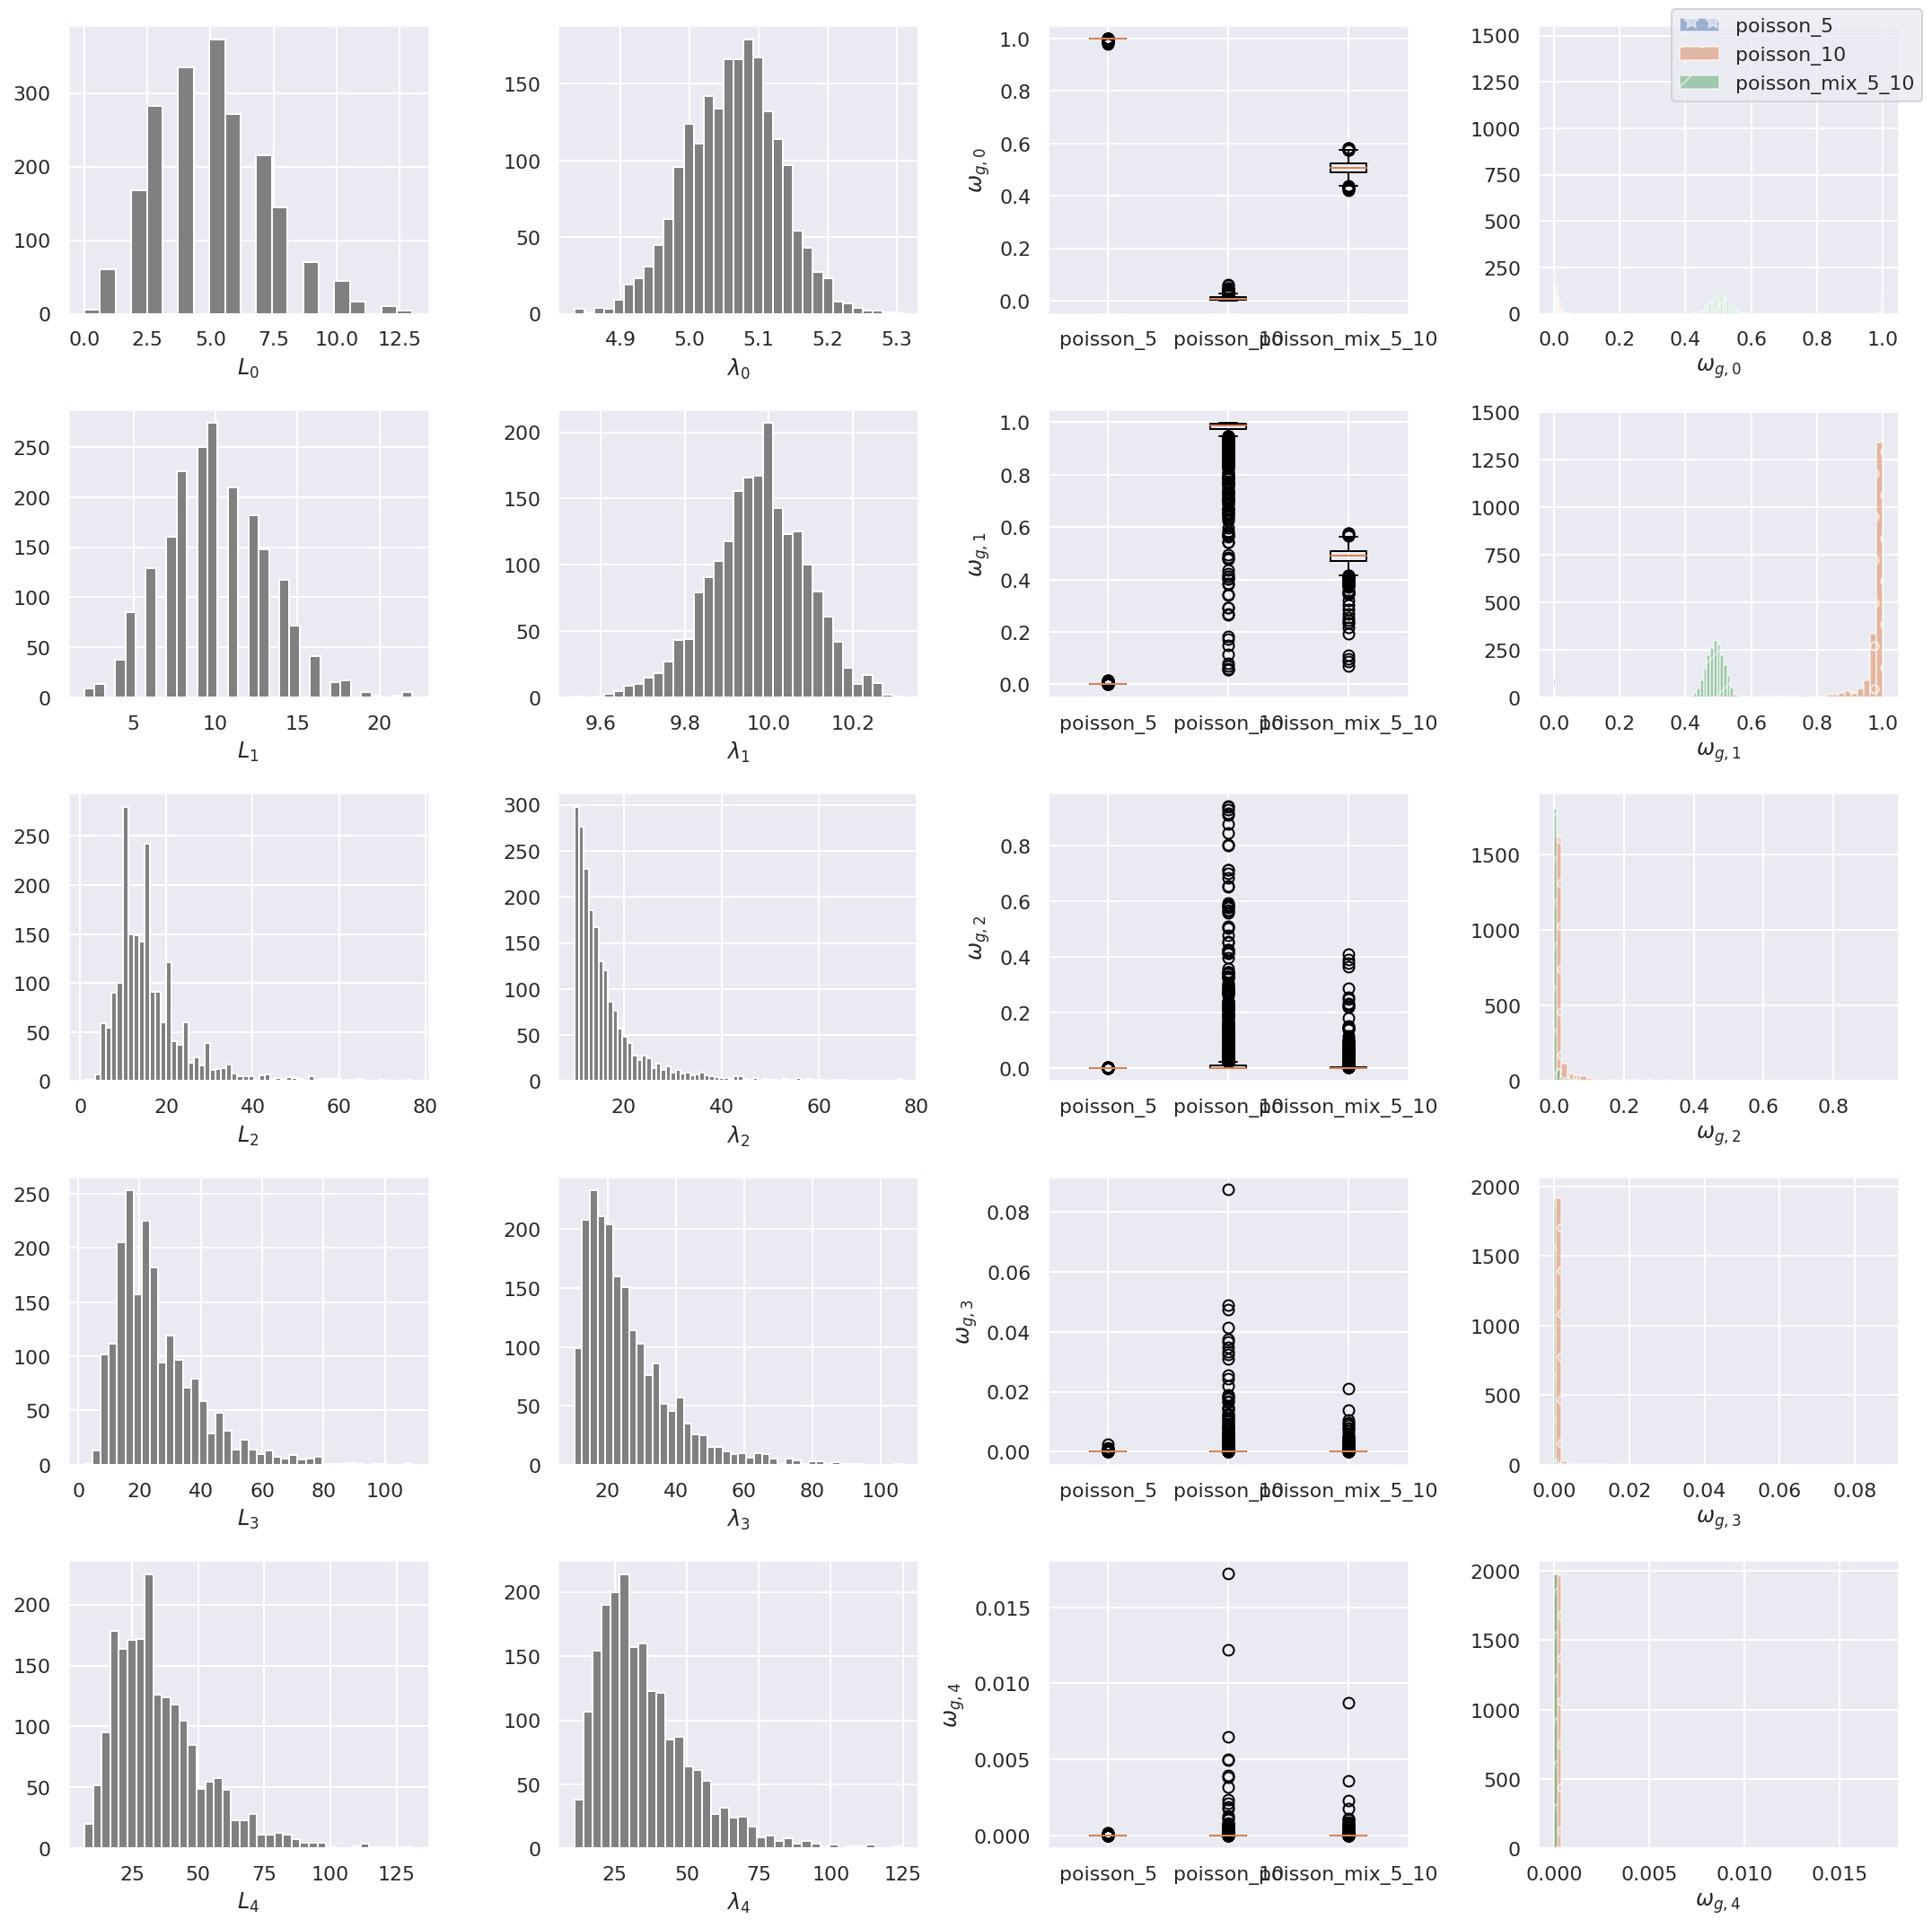

In [62]:
hatches = ['*', 'o', '/', '-']
fig, ax = plt.subplots(model.T, 4, figsize=(15, 15))
for t in range(model.T):
    _ = ax[t, 0].hist(np.random.poisson(posterior_samples['rate'][:, t]), color='gray', bins='auto')
    _ = ax[t, 0].set_xlabel(r'$L_{%d}$' % t)
    
    _ = ax[t, 1].hist(posterior_samples['rate'][:, t], color='gray', bins='auto')
    _ = ax[t, 1].set_xlabel(r'$\lambda_{%d}$' % t)
    
    _ = ax[t, 2].boxplot([posterior_samples['omega'][:,g,t].transpose() for g in range(model.G)])
    _ = ax[t, 2].set_xticklabels(model.group_names)
    _ = ax[t, 2].set_ylabel(r'$\omega_{g,%d}$' % t)    
    pal = cycle(sns.color_palette())
    for g in range(model.G):
       _ = ax[t, 3].hist(posterior_samples['omega'][:,g,t], alpha=0.5, color=next(pal), hatch=hatches[g], bins=50, label=model.group_names[g] if t==0 else None)
       _ = ax[t, 3].set_xlabel(r'$\omega_{g,%d}$' % t)
fig.legend()
fig.tight_layout(h_pad=1, w_pad=1)

In [96]:
def log_pdf(y, omega_g, rate):
    # w_g: [S, T]    
    # rate: [S, T]
    # x: [S, N] ->[N, S] -> [N, S, T]
    y = jnp.repeat(jnp.expand_dims(y, -1), omega_g.shape[-1], -1)
    # [1, S, T] + [N, S, T] -> [N, S] -> [N]
    return jnp.logaddexp(jnp.log(omega_g) + dist.Poisson(rate).log_prob(y), -1).mean(-1)

In [111]:
def kl_estimate(x, a, b, num_predictive_samples, num_posterior_samples, samples):
    S = samples['y'].shape[0]
    
    idx1 = np.random.choice(S, size=num_posterior_samples)
    #idx2 = np.random.choice(S, size=num_posterior_samples)
    rate1 = samples['rate'][idx1]
    rate2 = samples['rate'][idx1]
    
    idx1 = np.random.choice(S, size=num_posterior_samples)
    #idx2 = np.random.choice(S, size=num_posterior_samples)
    omega_a = samples['omega'][idx1, a]
    omega_b = samples['omega'][idx1, b]    

    # [K]
    idx_a = np.random.choice(len(x), p=(x==a)/(model.x==a).sum(-1), size=num_posterior_samples)
    idx1 = np.random.choice(S, size=num_posterior_samples)    
    y = samples['y'][idx1][np.arange(num_posterior_samples), idx_a]
    
    print((log_pdf(y, omega_a, rate1)-log_pdf(y, omega_b, rate2)).mean())
#     print(samples['y'][].shape)
    # sample y from a given group a    
#     log_pdf(y, omega_a, rate[idx1])
#     log_pdf(y, omega_b, rate[idx2])

In [112]:
kl_estimate(model.x, 0, 2, 30, 1000, posterior_samples)

-0.00013272924
